<h2>Imports and loading the dataset</h2><br>
This code cell handles all library and dataset importing.

In [1]:
 # standard libraries
import math, os, time, glob, random
import numpy as np

# plotting
import matplotlib.pyplot as plt

# progress bars
from tqdm.notebook import trange, tqdm

# PyTorch
import torch
import torch.nn as nn # lets not write out torch.nn every time
import torch.nn.functional as F # functional versions of the modules in torch.nn
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the stored numpy arrays
X = np.load("./sign-language-digits-dataset/X.npy")
Y = np.load("./sign-language-digits-dataset/Y.npy")

# lets inspect their shape
print(f"Shape of X: {X.shape}, shape of Y: {Y.shape}")

# Looks like we have 2062 samples, the images are 64x64 grayscale
# the labels look like they are stored as a probability distribution (a.k.a. one-hot encoding) over the 10 classes:
print(f"Y[0]={Y[0]}, Y[600]={Y[1000]}")

Shape of X: (2062, 64, 64), shape of Y: (2062, 10)
Y[0]=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Y[600]=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


We then convert the one-hot encoding (i.e. elements of {0,1}^10) to elements of {0,...,9}. This is done using the fact that only one vector element is nonzero, which implies that the argmax returns the index of the 1 (note that computer sequences start at zero so argmax maps into {0,...,9}).

In [2]:
Y = np.argmax(Y, -1)

print(f"Y[0]={Y[0]}, Y[600]={Y[1000]}")

Y[0]=0, Y[600]=4


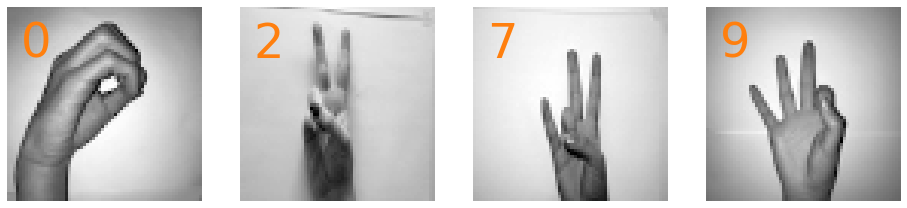

In [3]:
# Lets visualize some of the samples
show = (100, 600, 1500, 2000)
plt.figure(figsize=[4*len(show), 4])

for i in range(len(show)):
    plt.subplot(1, len(show), i+1)
    plt.imshow(X[show[i]], cmap='gray_r')
    plt.text(4, 4, f"{Y[show[i]]}", va='top' ,color='C1', fontsize=48)
    plt.axis("off")
    
plt.show()

We will now split the dataset into training and testing data, and set a random seed to make reproducible results. To split the dataset, we choose a random starting point such that X[start:end] has the right amount of elements. The testing dataset will then be defined as 'test dataset = dataset \ training dataset' (but in a way which NumPy understands), where \ denotes set theoretic difference. The random split is implemented in order to avoid overfitting on one particular split.

In [4]:
# 'Universal constants'
RANDOM_SEED = 694201337
NUMBER_OF_CLASSES = 10 # this avoids 'magic numbers' later in the code
DATASET_SIZE = X.shape[0]

# Hyper parameters
PERCENTAGE_TEST = 30
LEARNING_RATE = 0.007
BATCH_SIZE = 4
N_EPOCHS = 20


random.seed(RANDOM_SEED)

# Custom dataset split function before I realized that torch.utils.data.random_split exists
def split_train_test(X,Y):
    training_elements = round(DATASET_SIZE * (1-PERCENTAGE_TEST/100))
    start_point = random.randint(0, DATASET_SIZE - training_elements)

    X_train = X[start_point:start_point+training_elements]
    Y_train = Y[start_point:start_point+training_elements]

    X_test = np.concatenate((X[0:start_point], X[start_point+training_elements:]), axis=0)
    Y_test = np.concatenate((Y[0:start_point], Y[start_point+training_elements:]), axis=0)

    #terminate the program if train size + test size unequal tot DATASET_SIZE
    assert(not DATASET_SIZE - X_train.shape[0] - X_test.shape[0])
    
    return (X_train,Y_train,X_test,Y_test)

X = torch.tensor(X).unsqueeze(1).to(device)
Y = torch.tensor(Y).to(device)
dataset = torch.utils.data.TensorDataset(X,Y)

In [5]:
# Sanity check on list slicing/concatenation
A = [0,1,2,3,4,5,6,7,8,9,10,11]

#List slicing is non inclusive at the end
A[0:3]+A[6:9], [A[3],A[9]], np.concatenate((np.array(A[0:3]),np.array(A[6:9])),axis=0)

([0, 1, 2, 6, 7, 8], [3, 9], array([0, 1, 2, 6, 7, 8]))

<h2>The network architecture, and training the network</h2>

The network we will use is based on the LeNet-5 architecture (see, for example, https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320; the following code is based on this article). However we will make some modifications, in particular we will use ReLU activation functions rather than tanh. Furthermore the pictures in our dataset are twice the size of the ones in the MNIST dataset (for which LeNet-5 was created), to deal with this a MaxPool layer with 2×2 kernel will be added at the start.

In [6]:
class LeNet5_clone(nn.Module): # Class inherits from nn.Module
    
    def __init__(self, number_of_classes):
        super(LeNet5_clone, self).__init__()
        
        # We separate the network into a feature extractor and classifier 
        
        # This sequence contains the convolution layers, and works with picture data
        self.feature_extractor = nn.Sequential(
            # in: 1×64×64
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(), #6×60×60
            nn.AvgPool2d(kernel_size=2), #6×30×30
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(), #16×26×26
            nn.AvgPool2d(kernel_size=2), #16×13×13
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, stride=1),
            nn.ReLU() #64×9×9
        )
        
        # This sequence contains the fully connected layers and works on flattened data
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*9*9, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=number_of_classes),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        
        return logits,probs

class NN_2(nn.Module):
    def __init__(self):
        super(NN_2, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(), # 32×64×64
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 32×32×32
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(), # 64×32×32
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 64×16×16
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(), # 128×16×16
            nn.MaxPool2d(kernel_size = 2,stride = 2), # 128×8×8
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        
        return logits,probs
    
    

In [7]:
torch.manual_seed(RANDOM_SEED)

# We use our model based on LeNet-5 in combinations with the
# Adam optimizer using a cross-entropy loss function
model = LeNet5_clone(NUMBER_OF_CLASSES).to(device)
#model = NN_2().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# GPU stuff
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

LeNet5_clone(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=5184, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
    (3): ReLU()
  )
)


The following function defines the training sequence and is based on the following article.

In [8]:
def timestamp():
    t = time.localtime()
    return time.strftime('%Y_%b_%d_%H_%M_%S', t)

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')


def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss



def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            
    # Save the model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f"check_{timestamp()}.pth")

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [9]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
test_losses = []

test_size = round(DATASET_SIZE * PERCENTAGE_TEST/100)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, 
    [DATASET_SIZE - test_size, test_size])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, device)

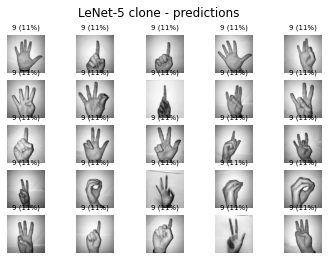

In [10]:
ROW_IMG = 5
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset[index][0].squeeze(0), cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 clone - predictions');

In [11]:
print(X.shape)
X = torch.rot90(X, 1, [2,3])

torch.Size([2062, 1, 64, 64])


In [12]:
X.shape

torch.Size([2062, 1, 64, 64])

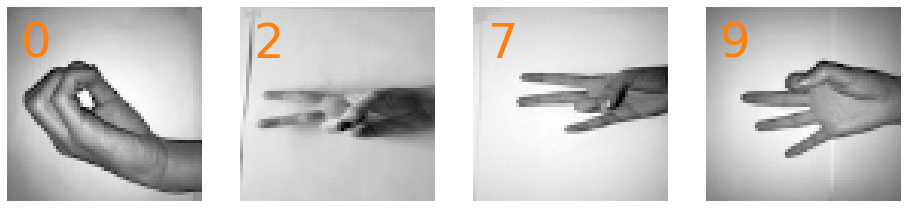

In [14]:
show = (100, 600, 1500, 2000)
plt.figure(figsize=[4*len(show), 4])

for i in range(len(show)):
    plt.subplot(1, len(show), i+1)
    plt.imshow(X.squeeze(1)[show[i]], cmap='gray_r')
    plt.text(4, 4, f"{Y[show[i]]}", va='top' ,color='C1', fontsize=48)
    plt.axis("off")
    
plt.show()

In [18]:
dataset = torch.utils.data.TensorDataset(X,Y)
loader = DataLoader(dataset=dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)
accuracy = get_accuracy(model, loader, device)

print(accuracy)

tensor(0.0989)


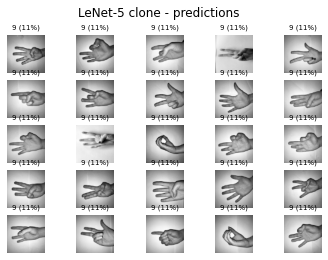

In [20]:
test_size = round(DATASET_SIZE * PERCENTAGE_TEST/100)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, 
    [DATASET_SIZE - test_size, test_size])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

ROW_IMG = 5
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset[index][0].squeeze(0), cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 clone - predictions');